In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

In [76]:
# Set seed for reproducibility
np.random.seed(42)

# Load California Housing dataset
housing = fetch_california_housing()
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['PRICE'] = housing.target

print("California Housing Dataset:")
print(f"Dataset shape: {df.shape}")
print("\nFeatures description:")
for i, feature in enumerate(housing.feature_names):
    print(f"{feature}: {housing.feature_names[i]}")
print("\nTarget variable: PRICE (median house value in $100,000s)")

California Housing Dataset:
Dataset shape: (20640, 9)

Features description:
MedInc: MedInc
HouseAge: HouseAge
AveRooms: AveRooms
AveBedrms: AveBedrms
Population: Population
AveOccup: AveOccup
Latitude: Latitude
Longitude: Longitude

Target variable: PRICE (median house value in $100,000s)


In [77]:
print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nSummary statistics:")
print(df.describe)


First 5 rows of the dataset:
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  PRICE  
0    -122.23  4.526  
1    -122.22  3.585  
2    -122.24  3.521  
3    -122.25  3.413  
4    -122.25  3.422  

Summary statistics:
<bound method NDFrame.describe of        MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0      8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1      8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2      7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3     

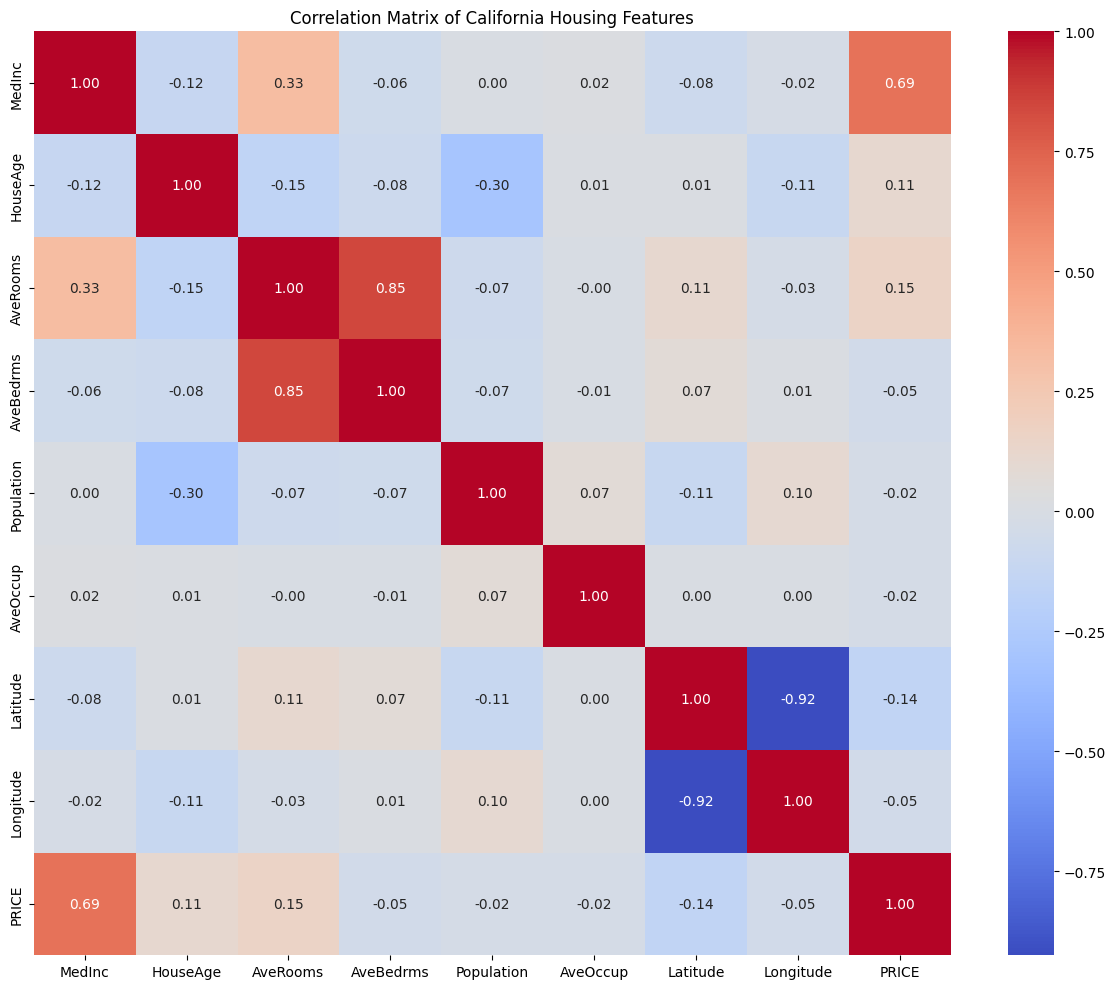

In [78]:
# Exploratory Data Analysis
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of California Housing Features')
plt.tight_layout()
plt.show() 

In [79]:
# Split data into features and target
X = df.drop('PRICE', axis=1)
y = df['PRICE']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [80]:
# Base model with all features
def evaluate_model(X_train, X_test, y_train, y_test, feature_names, model_name="Model"):
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Training predictions and evaluation
    y_train_pred = model.predict(X_train)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)
    train_r2 = r2_score(y_train, y_train_pred)
    
    # Test predictions and evaluation
    y_test_pred = model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Cross-validation for more robust evaluation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores.mean())
    
    # Calculate adjusted R-squared for test set
    n = X_test.shape[0]  # number of observations
    p = X_test.shape[1]  # number of predictors
    test_adj_r2 = 1 - (1 - test_r2) * (n - 1) / (n - p - 1)
    
    print(f"\n--- {model_name} Evaluation ---")
    print(f"Features used: {', '.join(feature_names)}")
    print(f"Number of features: {len(feature_names)}")
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Cross-validation RMSE: {cv_rmse:.4f}")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Test R²: {test_r2:.4f}")
    print(f"Test Adjusted R²: {test_adj_r2:.4f}")
    
    # Return the coefficient values along with evaluation metrics
    coefficients = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': model.coef_
    }).sort_values(by='Coefficient', ascending=False)
    
    result = {
        'model': model,
        'feature_names': feature_names,
        'test_rmse': test_rmse,
        'test_r2': test_r2,
        'test_adj_r2': test_adj_r2,
        'coefficients': coefficients,
        'cv_rmse': cv_rmse
    }
    
    return result

# Evaluate base model with all features
base_result = evaluate_model(
    X_train_scaled, X_test_scaled, y_train, y_test, 
    X.columns, "Base Model (All Features)"
)


--- Base Model (All Features) Evaluation ---
Features used: MedInc, HouseAge, AveRooms, AveBedrms, Population, AveOccup, Latitude, Longitude
Number of features: 8
Training RMSE: 0.7197
Test RMSE: 0.7456
Cross-validation RMSE: 0.7206
Training R²: 0.6126
Test R²: 0.5758
Test Adjusted R²: 0.5750


In [81]:
# Check for multicollinearity using VIF
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data.sort_values('VIF', ascending=False)

print("\nVariance Inflation Factors (VIF) for feature multicollinearity:")
vif_df = calculate_vif(X_train)
print(vif_df)


Variance Inflation Factors (VIF) for feature multicollinearity:
      Feature         VIF
7   Longitude  641.224254
6    Latitude  560.583263
3   AveBedrms   48.332634
2    AveRooms   46.792373
0      MedInc   11.831609
1    HouseAge    7.155405
4  Population    2.915730
5    AveOccup    1.080609


In [82]:
def forward_selection(X, y, significance_level=0.05):
    initial_features = []
    remaining_features = list(X.columns)
    
    selected_features = []
    history = []
    
    while remaining_features:
        best_pvalue = float('inf')
        best_feature = None
        best_r2_adj = -float('inf')
        
        for feature in remaining_features:
            current_features = selected_features + [feature]
            X_current = X[current_features]
            
            # Add constant for statsmodels
            X_with_const = sm.add_constant(X_current)
            model = sm.OLS(y, X_with_const).fit()
            
            # Get the p-value for the newest feature
            if len(current_features) == 1:
                p_value = model.pvalues[1]  # Skip constant
            else:
                p_value = model.pvalues[-1]  # Last feature added
                
            r2_adj = model.rsquared_adj
            
            if p_value < best_pvalue and p_value < significance_level:
                best_pvalue = p_value
                best_feature = feature
                best_r2_adj = r2_adj
        
        if best_feature is None:
            break
            
        selected_features.append(best_feature)
        remaining_features.remove(best_feature)
        
        # For tracking the selection process
        X_selected = X[selected_features]
        X_with_const = sm.add_constant(X_selected)
        model = sm.OLS(y, X_with_const).fit()
        
        history.append({
            'step': len(selected_features),
            'feature_added': best_feature,
            'p_value': best_pvalue,
            'r2': model.rsquared,
            'r2_adj': model.rsquared_adj
        })
        
        print(f"Step {len(selected_features)}: Added {best_feature} (p-value: {best_pvalue:.6f}, Adj R²: {best_r2_adj:.6f})")
    
    return selected_features, history

In [83]:
# Run Forward Selection
print("\n=== Forward Selection ===")
forward_features, forward_history = forward_selection(X_train, y_train)
print("\nSelected features:", forward_features)


=== Forward Selection ===
Step 1: Added MedInc (p-value: 0.000000, Adj R²: 0.476961)
Step 2: Added HouseAge (p-value: 0.000000, Adj R²: 0.512720)
Step 3: Added Latitude (p-value: 0.000000, Adj R²: 0.520719)
Step 4: Added Longitude (p-value: 0.000000, Adj R²: 0.597064)
Step 5: Added AveBedrms (p-value: 0.000000, Adj R²: 0.603173)
Step 6: Added AveRooms (p-value: 0.000000, Adj R²: 0.611151)
Step 7: Added AveOccup (p-value: 0.000000, Adj R²: 0.612383)

Selected features: ['MedInc', 'HouseAge', 'Latitude', 'Longitude', 'AveBedrms', 'AveRooms', 'AveOccup']


In [84]:
def backward_elimination(X, y, significance_level=0.05):
    selected_features = list(X.columns)
    history = []
    
    while selected_features:
        X_selected = X[selected_features]
        X_with_const = sm.add_constant(X_selected)
        model = sm.OLS(y, X_with_const).fit()
        
        # Find the feature with the highest p-value
        p_values = model.pvalues[1:]  # Skip constant
        max_p_value = p_values.max()
        
        if max_p_value > significance_level:
            # Find the feature with the highest p-value
            feature_to_remove = selected_features[p_values.argmax()]
            selected_features.remove(feature_to_remove)
            
            # For tracking the elimination process
            history.append({
                'step': len(X.columns) - len(selected_features),
                'feature_removed': feature_to_remove,
                'p_value': max_p_value,
                'r2': model.rsquared,
                'r2_adj': model.rsquared_adj
            })
            
            print(f"Step {len(history)}: Removed {feature_to_remove} (p-value: {max_p_value:.6f}, Adj R²: {model.rsquared_adj:.6f})")
        else:
            break
    
    return selected_features, history

In [85]:
# Run Backward Elimination
print("\n=== Backward Elimination ===")
backward_features, backward_history = backward_elimination(X_train, y_train)
print("\nSelected features:", backward_features)


=== Backward Elimination ===
Step 1: Removed Population (p-value: 0.698990, Adj R²: 0.612363)

Selected features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'AveOccup', 'Latitude', 'Longitude']


In [86]:
def stepwise_selection(X, y, significance_level=0.05):
    initial_features = []
    remaining_features = list(X.columns)
    
    selected_features = []
    history = []
    step_counter = 0
    
    while True:
        changed = False
        
        # Forward step
        best_pvalue = float('inf')
        best_feature = None
        best_r2_adj = -float('inf')
        
        for feature in remaining_features:
            current_features = selected_features + [feature]
            X_current = X[current_features]
            
            # Add constant for statsmodels
            X_with_const = sm.add_constant(X_current)
            model = sm.OLS(y, X_with_const).fit()
            
            # Get the p-value for the newest feature
            if len(current_features) == 1:
                p_value = model.pvalues[1]  # Skip constant
            else:
                p_value = model.pvalues[-1]  # Last feature added
                
            r2_adj = model.rsquared_adj
            
            if p_value < best_pvalue and p_value < significance_level:
                best_pvalue = p_value
                best_feature = feature
                best_r2_adj = r2_adj
        
        if best_feature is not None:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            changed = True
            step_counter += 1
            
            history.append({
                'step': step_counter,
                'action': 'added',
                'feature': best_feature,
                'p_value': best_pvalue,
                'r2_adj': best_r2_adj
            })
            
            print(f"Step {step_counter}: Added {best_feature} (p-value: {best_pvalue:.6f}, Adj R²: {best_r2_adj:.6f})")
        
        # Backward step
        if len(selected_features) > 0:
            X_selected = X[selected_features]
            X_with_const = sm.add_constant(X_selected)
            model = sm.OLS(y, X_with_const).fit()
            
            # Find the feature with the highest p-value
            p_values = model.pvalues[1:]  # Skip constant
            max_p_value = p_values.max() if len(p_values) > 0 else 0
            
            if max_p_value > significance_level:
                # Find the feature with the highest p-value
                feature_idx = p_values.argmax()
                feature_to_remove = selected_features[feature_idx]
                selected_features.remove(feature_to_remove)
                remaining_features.append(feature_to_remove)
                changed = True
                step_counter += 1
                
                # For tracking the elimination process
                history.append({
                    'step': step_counter,
                    'action': 'removed',
                    'feature': feature_to_remove,
                    'p_value': max_p_value,
                    'r2_adj': model.rsquared_adj
                })
                
                print(f"Step {step_counter}: Removed {feature_to_remove} (p-value: {max_p_value:.6f}, Adj R²: {model.rsquared_adj:.6f})")
        
        if not changed:
            break
    
    return selected_features, history

In [87]:
# Run Stepwise Selection
print("\n=== Stepwise Selection ===")
stepwise_features, stepwise_history = stepwise_selection(X_train, y_train)
print("\nSelected features:", stepwise_features)


=== Stepwise Selection ===
Step 1: Added MedInc (p-value: 0.000000, Adj R²: 0.476961)
Step 2: Added HouseAge (p-value: 0.000000, Adj R²: 0.512720)
Step 3: Added Latitude (p-value: 0.000000, Adj R²: 0.520719)
Step 4: Added Longitude (p-value: 0.000000, Adj R²: 0.597064)
Step 5: Added AveBedrms (p-value: 0.000000, Adj R²: 0.603173)
Step 6: Added AveRooms (p-value: 0.000000, Adj R²: 0.611151)
Step 7: Added AveOccup (p-value: 0.000000, Adj R²: 0.612383)

Selected features: ['MedInc', 'HouseAge', 'Latitude', 'Longitude', 'AveBedrms', 'AveRooms', 'AveOccup']


In [88]:
# Evaluate Forward Selection model
forward_X_train = X_train[forward_features]
forward_X_test = X_test[forward_features]

# Standardize selected features
forward_X_train_scaled = scaler.fit_transform(forward_X_train)
forward_X_test_scaled = scaler.transform(forward_X_test)

forward_result = evaluate_model(
    forward_X_train_scaled, forward_X_test_scaled, y_train, y_test, 
    forward_features, "Forward Selection Model"
)

# Evaluate Backward Elimination model
backward_X_train = X_train[backward_features]
backward_X_test = X_test[backward_features]

# Standardize selected features
backward_X_train_scaled = scaler.fit_transform(backward_X_train)
backward_X_test_scaled = scaler.transform(backward_X_test)

backward_result = evaluate_model(
    backward_X_train_scaled, backward_X_test_scaled, y_train, y_test, 
    backward_features, "Backward Elimination Model"
)

# Evaluate Stepwise Selection model
stepwise_X_train = X_train[stepwise_features]
stepwise_X_test = X_test[stepwise_features]

# Standardize selected features
stepwise_X_train_scaled = scaler.fit_transform(stepwise_X_train)
stepwise_X_test_scaled = scaler.transform(stepwise_X_test)

stepwise_result = evaluate_model(
    stepwise_X_train_scaled, stepwise_X_test_scaled, y_train, y_test, 
    stepwise_features, "Stepwise Selection Model"
)


--- Forward Selection Model Evaluation ---
Features used: MedInc, HouseAge, Latitude, Longitude, AveBedrms, AveRooms, AveOccup
Number of features: 7
Training RMSE: 0.7197
Test RMSE: 0.7456
Cross-validation RMSE: 0.7206
Training R²: 0.6125
Test R²: 0.5757
Test Adjusted R²: 0.5750

--- Backward Elimination Model Evaluation ---
Features used: MedInc, HouseAge, AveRooms, AveBedrms, AveOccup, Latitude, Longitude
Number of features: 7
Training RMSE: 0.7197
Test RMSE: 0.7456
Cross-validation RMSE: 0.7206
Training R²: 0.6125
Test R²: 0.5757
Test Adjusted R²: 0.5750

--- Stepwise Selection Model Evaluation ---
Features used: MedInc, HouseAge, Latitude, Longitude, AveBedrms, AveRooms, AveOccup
Number of features: 7
Training RMSE: 0.7197
Test RMSE: 0.7456
Cross-validation RMSE: 0.7206
Training R²: 0.6125
Test R²: 0.5757
Test Adjusted R²: 0.5750


In [89]:
# Compare all models
models_comparison = pd.DataFrame({
    'Model': ['Base Model (All Features)', 'Forward Selection', 'Backward Elimination', 'Stepwise Selection'],
    'Features': [len(base_result['feature_names']), len(forward_result['feature_names']), 
                len(backward_result['feature_names']), len(stepwise_result['feature_names'])],
    'Test RMSE': [base_result['test_rmse'], forward_result['test_rmse'], 
                 backward_result['test_rmse'], stepwise_result['test_rmse']],
    'Test R²': [base_result['test_r2'], forward_result['test_r2'], 
               backward_result['test_r2'], stepwise_result['test_r2']],
    'Test Adjusted R²': [base_result['test_adj_r2'], forward_result['test_adj_r2'], 
                        backward_result['test_adj_r2'], stepwise_result['test_adj_r2']],
    'CV RMSE': [base_result['cv_rmse'], forward_result['cv_rmse'], 
               backward_result['cv_rmse'], stepwise_result['cv_rmse']]
})

print("\n=== Model Comparison ===")
print(models_comparison)


=== Model Comparison ===
                       Model  Features  Test RMSE   Test R²  Test Adjusted R²  \
0  Base Model (All Features)         8   0.745581  0.575788          0.574964   
1          Forward Selection         7   0.745623  0.575741          0.575020   
2       Backward Elimination         7   0.745623  0.575741          0.575020   
3         Stepwise Selection         7   0.745623  0.575741          0.575020   

    CV RMSE  
0  0.720601  
1  0.720558  
2  0.720558  
3  0.720558  


([0, 1, 2, 3],
 [Text(0, 0, 'Base Model (All Features)'),
  Text(1, 0, 'Forward Selection'),
  Text(2, 0, 'Backward Elimination'),
  Text(3, 0, 'Stepwise Selection')])

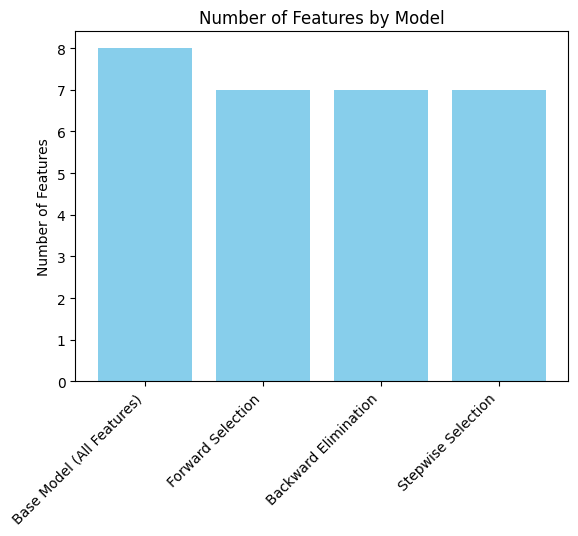

In [90]:
# Visualize model comparison
plt.figure(figsize=(14, 10))

# Plot 1: Number of Features
plt.subplot(2, 2, 1)
plt.bar(models_comparison['Model'], models_comparison['Features'], color='skyblue')
plt.title('Number of Features by Model')
plt.ylabel('Number of Features')
plt.xticks(rotation=45, ha='right')

([0, 1, 2, 3],
 [Text(0, 0, 'Base Model (All Features)'),
  Text(1, 0, 'Forward Selection'),
  Text(2, 0, 'Backward Elimination'),
  Text(3, 0, 'Stepwise Selection')])

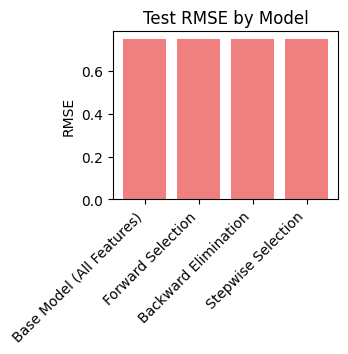

In [91]:
# Plot 2: Test RMSE
plt.subplot(2, 2, 2)
plt.bar(models_comparison['Model'], models_comparison['Test RMSE'], color='lightcoral')
plt.title('Test RMSE by Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45, ha='right')

([0, 1, 2, 3],
 [Text(0, 0, 'Base Model (All Features)'),
  Text(1, 0, 'Forward Selection'),
  Text(2, 0, 'Backward Elimination'),
  Text(3, 0, 'Stepwise Selection')])

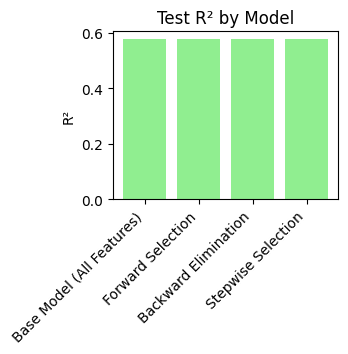

In [92]:
# Plot 3: Test R²
plt.subplot(2, 2, 3)
plt.bar(models_comparison['Model'], models_comparison['Test R²'], color='lightgreen')
plt.title('Test R² by Model')
plt.ylabel('R²')
plt.xticks(rotation=45, ha='right')

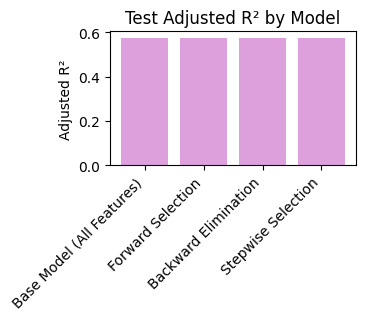

In [93]:
# Plot 4: Test Adjusted R²
plt.subplot(2, 2, 4)
plt.bar(models_comparison['Model'], models_comparison['Test Adjusted R²'], color='plum')
plt.title('Test Adjusted R² by Model')
plt.ylabel('Adjusted R²')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()  

# Plot the progression of Adjusted R² during selection methods
# plt.figure(figsize=(12, 6))

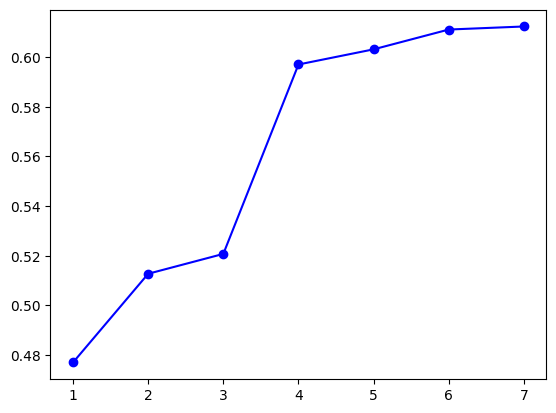

In [94]:
# Forward Selection
forward_df = pd.DataFrame(forward_history)
if not forward_df.empty:
    plt.plot(forward_df['step'], forward_df['r2_adj'], marker='o', label='Forward Selection', color='blue')


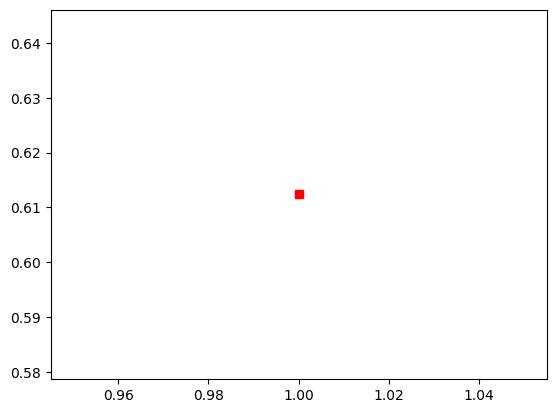

In [95]:
# Backward Elimination
backward_df = pd.DataFrame(backward_history)
if not backward_df.empty:
    # For backward elimination, we plot from the end to the beginning for comparison
    plt.plot(range(1, len(backward_df) + 1), backward_df['r2_adj'], marker='s', label='Backward Elimination', color='red')

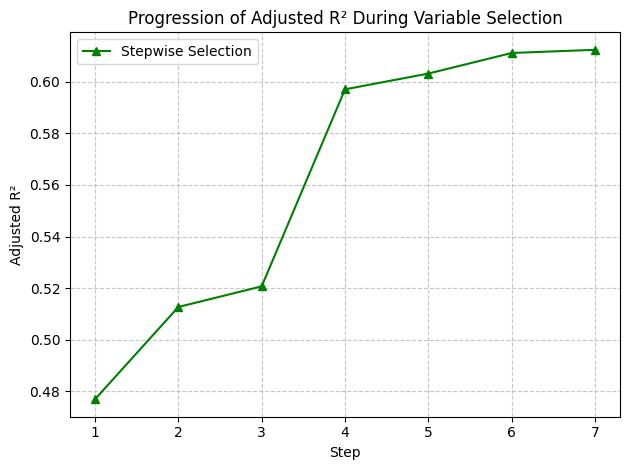

In [96]:
# Stepwise Selection
stepwise_df = pd.DataFrame(stepwise_history)
if not stepwise_df.empty:
    plt.plot(stepwise_df['step'], stepwise_df['r2_adj'], marker='^', label='Stepwise Selection', color='green')

plt.title('Progression of Adjusted R² During Variable Selection')
plt.xlabel('Step')
plt.ylabel('Adjusted R²')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show() 

In [97]:
# Final model selection based on Adjusted R² and RMSE
best_model_idx = models_comparison['Test Adjusted R²'].idxmax()
best_model_name = models_comparison.loc[best_model_idx, 'Model']
print(f"\nBest model based on Test Adjusted R²: {best_model_name}")

# Show the best model's features and coefficients
if best_model_name == 'Forward Selection':
    best_result = forward_result
elif best_model_name == 'Backward Elimination':
    best_result = backward_result
elif best_model_name == 'Stepwise Selection':
    best_result = stepwise_result
else:
    best_result = base_result

print("\nBest model's features and coefficients:")
print(best_result['coefficients'])


Best model based on Test Adjusted R²: Forward Selection

Best model's features and coefficients:
     Feature  Coefficient
0     MedInc     0.854474
4  AveBedrms     0.339299
1   HouseAge     0.123310
6   AveOccup    -0.041013
5   AveRooms    -0.294240
3  Longitude    -0.869372
2   Latitude    -0.896275


In [98]:
# Conclusion
print("\n=== Conclusion ===")
print(f"The {best_model_name} performed best with an Adjusted R² of {models_comparison.loc[best_model_idx, 'Test Adjusted R²']:.4f}")
print(f"Features selected: {', '.join(best_result['feature_names'])}")
print(f"This represents a {100 * (1 - len(best_result['feature_names']) / len(base_result['feature_names'])):.1f}% reduction in features compared to the base model")
print(f"The model had a Test RMSE of {models_comparison.loc[best_model_idx, 'Test RMSE']:.4f}")


=== Conclusion ===
The Forward Selection performed best with an Adjusted R² of 0.5750
Features selected: MedInc, HouseAge, Latitude, Longitude, AveBedrms, AveRooms, AveOccup
This represents a 12.5% reduction in features compared to the base model
The model had a Test RMSE of 0.7456


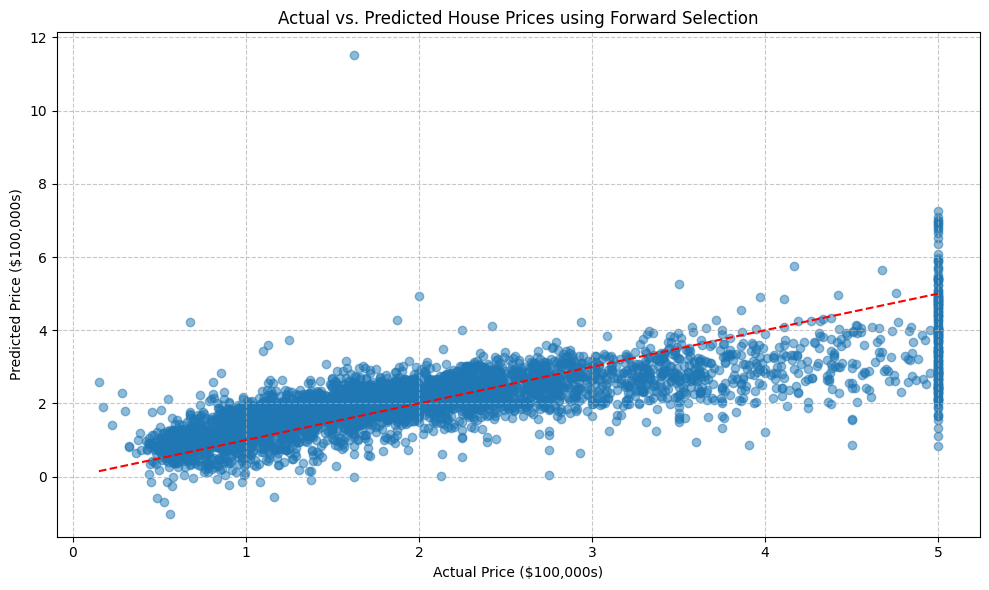

In [99]:
# Plot actual vs predicted for the best model
if best_model_name == 'Forward Selection':
    best_X_test_scaled = forward_X_test_scaled
elif best_model_name == 'Backward Elimination':
    best_X_test_scaled = backward_X_test_scaled
elif best_model_name == 'Stepwise Selection':
    best_X_test_scaled = stepwise_X_test_scaled
else:
    best_X_test_scaled = X_test_scaled

best_model = best_result['model']
y_pred = best_model.predict(best_X_test_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Price ($100,000s)')
plt.ylabel('Predicted Price ($100,000s)')
plt.title(f'Actual vs. Predicted House Prices using {best_model_name}')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()